In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import logging
from dataset import DataloaderImg, GreyToRGB, NormalizeVolume
from torch import optim
import torchvision.transforms.v2 as tfms

plt.ion()  # interactive mode

# install pytorch correctly
# https://discuss.pytorch.org/t/torch-cuda-is-not-available/74845/11

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
logging.basicConfig(
    level=logging.INFO,
)
# install cuda driver ubuntu
# https://ubuntu.com/server/docs/nvidia-drivers-installation

cuda


In [2]:
# https://pytorch.org/docs/stable/cuda.html
# torch.cuda.is_initialized()

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"Current cuda device: {torch.cuda.get_device_name(current_device)}")

Current cuda device: NVIDIA RTX A2000


In [3]:
# script for segmentation
# https://github.com/mateuszbuda/brain-segmentation-pytorch

In [28]:
# help in loading images
# https://discuss.pytorch.org/t/how-to-load-all-the-nii-from-the-directory-without-augmentation-using-pytorch-dataloader/60938/3
root_dir = "/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train"  #!NOTE: delete "/train" for all subjects

custom_transforms = [NormalizeVolume(), GreyToRGB()]
transforms = [tfms.RandomRotation(180)]
n_validation = 2
# full_dataset = Dataloder_img('C:/Users/Ali ktk/.spyder-py3/dataloader/data/train/1', 'C:/Users/Ali ktk/.spyder-py3/dataloader/data/train/1/ADNI_136_S_0300_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080529142830882_S50401_I107759.nii' ,tfms.Compose([tfms.RandomRotation(180).tfms.ToTensor()]))
train_dataset = DataloaderImg(
    root_dir,
    subset="train",
    validation_cases=n_validation,
    custom_transforms=custom_transforms,
    transforms=transforms,
)
validation_dataset = DataloaderImg(
    root_dir,
    subset="validation",
    validation_cases=n_validation,
    custom_transforms=custom_transforms,
    transforms=transforms,
)

/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-1/run-01/petra_.nii.gz /media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-1/run-01/cylinder_plus_plug_ROI_FN.nii.gz
/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-2/run-01/petra_.nii.gz /media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-2/run-01/cylinder_plus_plug_ROI_FN.nii.gz
/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-2/run-02/petra_.nii.gz /media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-2/run-02/cylinder_plus_plug_ROI_FN.nii.gz
/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-3/run-01/petra_.nii.gz /media/MeMoSLAP_Subjects/derivati

volume Size: 18579456
mask Size: 18579456
volume Size: 18579456
mask Size: 18579456


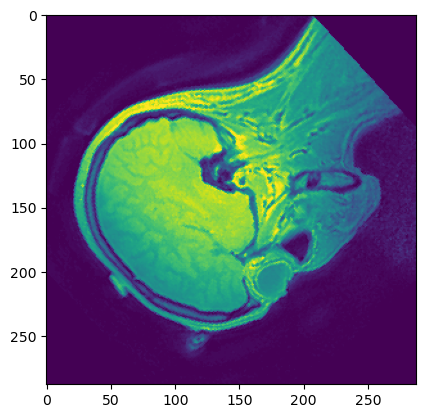

In [37]:
loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

train_img, train_mask = next(iter(loader))

plt.imshow(train_img[0][1])

In [38]:
model = torch.hub.load(
    "mateuszbuda/brain-segmentation-pytorch",
    "unet",
    in_channels=3,
    out_channels=1,
    init_features=32,
    pretrained=False,
)

Using cache found in /home/riemanns/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [39]:
model.to(device)
model.train()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [41]:
import torch.nn as nn


class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2.0 * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1.0 - dsc

In [42]:
dsc_loss = DiceLoss()
best_validation_dsc = 0.0

optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_train = []
loss_valid = []

# * epoch loop

validation_pred = []
validation_true = []

phase = "train"

for i, data in enumerate(loader):
    x, y_true = data
    x, y_true = x.to(device, dtype=torch.float), y_true.to(device)

    optimizer.zero_grad()

    with torch.set_grad_enabled(phase == "train"):
        y_pred = model(x)
        loss = dsc_loss(y_pred, y_true)

        if phase == "train":
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

# * end epoch loop

# if phase == "train" and (step + 1) % 10 == 0:
#     print(
#         f"Epoch [{epoch}/{num_epochs}], Step [{step}/{total_step}], Loss: {loss.item():.4f}"
#     )

volume Size: 18579456
mask Size: 18579456
volume Size: 18579456
mask Size: 18579456
volume Size: 18579456
mask Size: 18579456
volume Size: 18579456
mask Size: 18579456
volume Size: 18579456
mask Size: 18579456


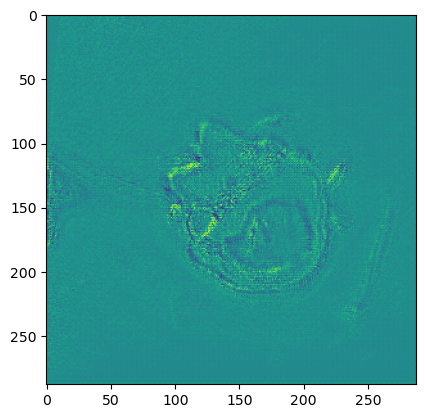

In [35]:
plt.imshow(y_pred[0][0].cpu().detach().numpy())

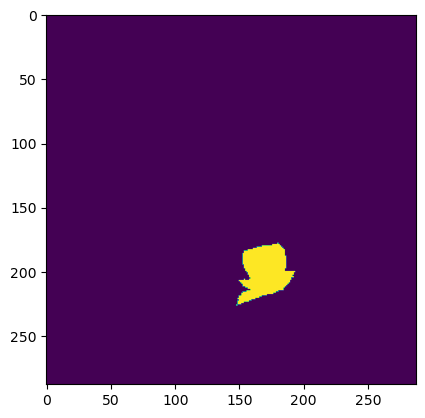

In [36]:
plt.imshow(y_true[0][0].detach().cpu().numpy())

In [27]:
y_true.size()

torch.Size([1, 1, 288, 288])